In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Preprocessing


In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df["TotalCharges"] = df["TotalCharges"].str.strip()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])
df = df.dropna()
df.info()
preprocessor = ColumnTransformer(
    transformers=[
        ('senior',MinMaxScaler(),['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']),
    ],
    remainder=OrdinalEncoder()
)
X = df.drop(['customerID','Churn'],axis=1)
y= df['Churn']

X = preprocessor.fit_transform(X)
y = y.map({'No':0,'Yes':1})

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

# Applying PCA to reduce Dimensions

In [3]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
X_pca_train,X_pca_test,y_train,y_test = train_test_split(X_pca,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

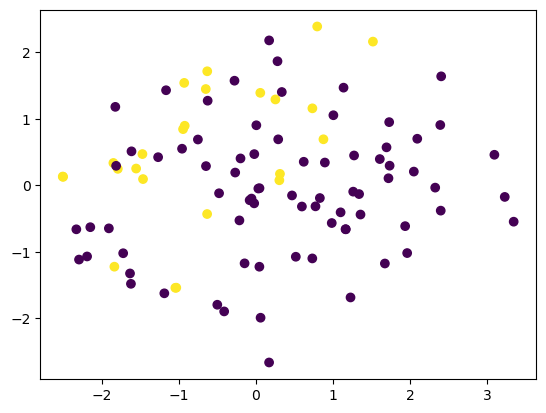

In [4]:
plt.scatter(X_pca[:100,0],X_pca[:100,1],c=y[:100])

# XGBClassifier

In [8]:
import optuna
ones = np.sum(y_test==1)
zeros = np.sum(y_test==0)

scale_pos_weight = zeros/ones

def objective (trial):
    learning_rate = trial.suggest_float('lr',0.01,0.2)
    max_depth = trial.suggest_int('md',5,15)
    max_leaves = trial.suggest_int('ml',2,10)
    gamma = trial.suggest_float('g',0.001,0.2)

    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth= max_depth,
        device= 'cuda',
        max_leaves=max_leaves,
        gamma= gamma,
        random_state=42,
        # scale_pos_weight= scale_pos_weight
    )

    model.fit(X_pca_train,y_train)
    y_pred = model.predict(X_pca_test)
    return f1_score(y_test,y_pred) 
    
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_jobs=-1,n_trials=80)


print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# 'lr': 0.0948987889033309, 'md': 10, 'ml': 8, 'g': 0.07270327803602415 on normal dataset 

[I 2025-07-16 12:36:16,867] A new study created in memory with name: no-name-5ee33885-2495-40a8-9de8-b84d52cf5d8b
[I 2025-07-16 12:36:20,257] Trial 4 finished with value: 0.38267148014440433 and parameters: {'lr': 0.08171990079791076, 'md': 13, 'ml': 2, 'g': 0.037490705911750535}. Best is trial 4 with value: 0.38267148014440433.
[I 2025-07-16 12:36:20,288] Trial 6 finished with value: 0.08888888888888889 and parameters: {'lr': 0.03258250825049726, 'md': 7, 'ml': 2, 'g': 0.14439663961601382}. Best is trial 4 with value: 0.38267148014440433.
[I 2025-07-16 12:36:20,294] Trial 2 finished with value: 0.22566371681415928 and parameters: {'lr': 0.042202574146117174, 'md': 14, 'ml': 2, 'g': 0.04146764164219531}. Best is trial 4 with value: 0.38267148014440433.
[I 2025-07-16 12:36:20,620] Trial 7 finished with value: 0.0 and parameters: {'lr': 0.013050953435533296, 'md': 6, 'ml': 4, 'g': 0.18994276075708616}. Best is trial 4 with value: 0.38267148014440433.
[I 2025-07-16 12:36:20,637] Trial 3 f

Best hyperparameters: {'lr': 0.14426462361950418, 'md': 9, 'ml': 7, 'g': 0.00918106826565122}
Best accuracy: 0.5321888412017167


# RandomForestClassifier

In [47]:
def objective (trial):
    params ={
        'max_depth' : trial.suggest_int('md',2,10), 
        'min_samples_split' : trial.suggest_float('mss',0.0001,1), 
        'min_samples_leaf' : trial.suggest_int('msl',1,10), 
        'min_weight_fraction_leaf' : trial.suggest_float('mwfl',0,0.5), 
        'max_leaf_nodes' : trial.suggest_int('mln',10,200),
        'min_impurity_decrease' :trial.suggest_float('mid',0.001,1), 
        'class_weight' : 'balanced'
    }
    model = RandomForestClassifier(
        **params,
        random_state=42,
        n_estimators=100,
        verbose=0
    )
    model.fit(X_pca_train,y_train)
    y_pred = model.predict(X_pca_test)
    return accuracy_score(y_test,y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=50,n_jobs=-1)

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-07-16 12:16:33,520] A new study created in memory with name: no-name-d5fafadb-7b10-4071-9981-7f4495bd4aff
[I 2025-07-16 12:16:35,104] Trial 2 finished with value: 0.7341862117981521 and parameters: {'md': 3, 'mss': 0.7840151541433223, 'msl': 6, 'mwfl': 0.02152675953531491, 'mln': 182, 'mid': 0.35339270022602337}. Best is trial 2 with value: 0.7341862117981521.
[I 2025-07-16 12:16:35,107] Trial 1 finished with value: 0.7341862117981521 and parameters: {'md': 8, 'mss': 0.7650741511315601, 'msl': 2, 'mwfl': 0.009490323157536285, 'mln': 133, 'mid': 0.33680938592347026}. Best is trial 2 with value: 0.7341862117981521.
[I 2025-07-16 12:16:35,175] Trial 6 finished with value: 0.7341862117981521 and parameters: {'md': 4, 'mss': 0.8454464289517599, 'msl': 2, 'mwfl': 0.19943925564473924, 'mln': 186, 'mid': 0.8815469587930955}. Best is trial 2 with value: 0.7341862117981521.
[I 2025-07-16 12:16:35,224] Trial 4 finished with value: 0.7341862117981521 and parameters: {'md': 10, 'mss': 0.821

Best hyperparameters: {'md': 2, 'mss': 0.1682176825339712, 'msl': 2, 'mwfl': 0.4043676844303467, 'mln': 196, 'mid': 0.03767760300927262}
Best accuracy: 0.7469793887704336


# Final Model

In [ ]:
params = {
    'learning_rate': 0.0948987889033309, 'max_depth': 10, 'max_leaves': 8, 'gamma': 0.07270327803602415 , 'device' : 'cuda', 'random_state' : 42
}
model = XGBClassifier(
    **params
)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1407
   macro avg       0.76      0.71      0.73      1407
weighted avg       0.80      0.81      0.80      1407



# Evaluating

Classification_report
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1407
   macro avg       0.76      0.71      0.73      1407
weighted avg       0.80      0.81      0.80      1407



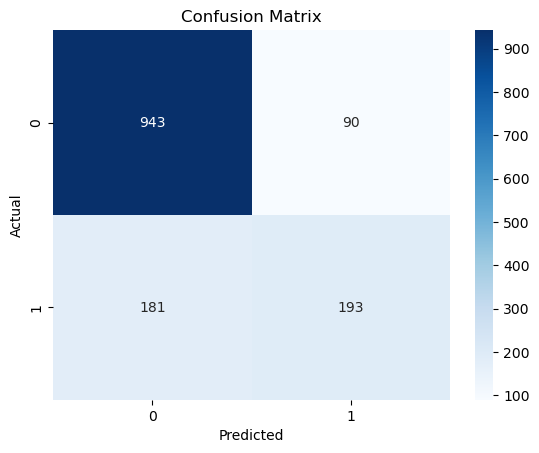

In [ ]:
cr = classification_report(y_test,y_pred)
print('Classification_report\n',cr)

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 0 : No Churn
# 1 : Churn